In [ ]:
# MediWatch Exploratory Data Analysis

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline


# Additional modules for model training
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [85]:
# Read the Diabetic Data CSV file
df = pd.read_csv('/data/diabetic_data.csv')

In [86]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [87]:
# Identify the Target Variable
df['readmitted'].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

This indicates a 3-class classification problem, where <30 represents readmissions within 30 days (often considered the most critical outcome), >30 is readmissions after 30 days, and NO is no readmission. The target distribution is somewhat imbalanced, with the <30 category being relatively rare.

## Data-Preprocessing

In [88]:
# 1. Handle 'max_glu_serum' and 'A1Cresult':
# Replace 'Norm' with 'normal'
df['max_glu_serum'] = df['max_glu_serum'].replace({'Norm': 'normal'})
df['A1Cresult'] = df['A1Cresult'].replace({'Norm': 'normal'})

# Replace NaN in these columns with 'none'
df['max_glu_serum'] = df['max_glu_serum'].fillna('none')
df['A1Cresult'] = df['A1Cresult'].fillna('none')

# Now 'max_glu_serum' should have categories like ['none', 'normal', '>200', '>300']
# And 'A1Cresult' should have ['none', 'normal', '>7', '>8']

- For max_glu_serum, none means not tested, while >200 and >300 indicate severe glucose levels.
- For A1Cresult, similarly, none means not tested, while >7 and >8 indicate poor glycemic control and normal is within normal range.

In [89]:
df['A1Cresult'].value_counts()

A1Cresult
none      84748
>8         8216
normal     4990
>7         3812
Name: count, dtype: int64

In [90]:
# 2. Drop 'weight' due to excessive missingness (97% missing)
df.drop(columns=['weight'], inplace=True)

# 3. Handle Categorical Features with Missing Values:
# For 'payer_code' and 'medical_specialty', replace missing values with 'Unknown'
df['payer_code'] = df['payer_code'].fillna('Unknown')
df['medical_specialty'] = df['medical_specialty'].fillna('Unknown')

In [91]:
df['payer_code'].value_counts()

payer_code
?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64

In [92]:
# Replace '?' With 'Unknown'
df['payer_code'] = df['payer_code'].replace('?', 'Unknown')
df['medical_specialty'] = df['medical_specialty'].replace('?', 'Unknown')

In [93]:
df['diag_3'].value_counts()

diag_3
250     11555
401      8289
276      5175
428      4577
427      3955
        ...  
657         1
684         1
603         1
E826        1
971         1
Name: count, Length: 790, dtype: int64

In [94]:
# 4. Reduce Cardinality of Diagnosis Codes
# International Classification of Diseases (ICD). Map ICD codes to broader categories. 

def map_icd_to_category(icd):
    if icd == 'Unknown':
        return 'Unknown'
    icd = str(icd)
    # Attempt to convert to float to identify numeric ICD codes
    # ICD code ranges (based on ICD-9) can be mapped to categories:
    # 001–139: Infectious and parasitic diseases
    # 140–239: Neoplasms
    # 240–279: Endocrine, nutritional & metabolic diseases, and immunity disorders
    # 280–289: Diseases of the blood and blood-forming organs
    # ... (This is a simplified approach, real mapping is more detailed)
    try:
        code_num = float(icd)
        if 1 <= code_num < 140:
            return 'Infectious_and_Parasitic'
        elif 140 <= code_num < 240:
            return 'Neoplasms'
        elif 240 <= code_num < 280:
            return 'Endocrine_Metabolic'
        elif 280 <= code_num < 290:
            return 'Blood_And_Blood_forming_Organs'
        else:
            return 'Other'
    except ValueError:
        # For codes starting with 'V' or 'E'
        if icd.startswith('V'):
            return 'Supplementary_Factors'
        elif icd.startswith('E'):
            return 'External_Causes_of_Injury'
        else:
            return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].apply(map_icd_to_category)

In [95]:
# Load and create dictionaries for the three ID mappings
admission_type_map = pd.read_csv('/data/admission_type_mapping.csv', usecols=['admission_type_id','description']).dropna()
discharge_disposition_map = pd.read_csv('/data/discharge_disposition_mapping.csv', usecols=['discharge_disposition_id','description']).dropna()
admission_source_map = pd.read_csv('/data/admission_source_mapping.csv', usecols=['admission_source_id','description']).dropna()

admission_type_dict = dict(zip(admission_type_map['admission_type_id'], admission_type_map['description']))
discharge_disposition_dict = dict(zip(discharge_disposition_map['discharge_disposition_id'], discharge_disposition_map['description']))
admission_source_dict = dict(zip(admission_source_map['admission_source_id'], admission_source_map['description']))

# Map them onto main df
df['admission_type'] = df['admission_type_id'].map(admission_type_dict)
df['discharge_disposition'] = df['discharge_disposition_id'].map(discharge_disposition_dict)
df['admission_source'] = df['admission_source_id'].map(admission_source_dict)

df.drop(columns=['admission_type_id','discharge_disposition_id','admission_source_id'], inplace=True)

# Standardize unknown categories if necessary
df['admission_type'] = df['admission_type'].replace(['Not Mapped', 'NULL', 'Unknown/Invalid'], 'Unknown')
df['discharge_disposition'] = df['discharge_disposition'].replace(['Not Mapped', 'NULL', 'Unknown/Invalid'], 'Unknown')
df['admission_source'] = df['admission_source'].replace(['Not Mapped', 'NULL', 'Unknown/Invalid'], 'Unknown')

In [96]:
print(df['admission_type'].value_counts())
print(df['discharge_disposition'].value_counts())
print(df['admission_source'].value_counts())

admission_type
Emergency        53990
Elective         18869
Urgent           18480
Not Available     4785
Unknown            320
Trauma Center       21
Newborn             10
Name: count, dtype: int64
discharge_disposition
Discharged to home                                                                                           60234
Discharged/transferred to SNF                                                                                13954
Discharged/transferred to home with home health service                                                      12902
Discharged/transferred to another short term hospital                                                         2128
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1993
Expired                                                                                                       1642
Discharged/transferred to another type of inpatient care institution                  

In [97]:
# Percentage distribution for each feature
print(df['admission_type'].value_counts(normalize=True) * 100)
print(df['discharge_disposition'].value_counts(normalize=True) * 100)
print(df['admission_source'].value_counts(normalize=True) * 100)

admission_type
Emergency        55.962685
Elective         19.558435
Urgent           19.155222
Not Available     4.959834
Unknown           0.331692
Trauma Center     0.021767
Newborn           0.010365
Name: proportion, dtype: float64
discharge_disposition
Discharged to home                                                                                           61.416263
Discharged/transferred to SNF                                                                                14.227887
Discharged/transferred to home with home health service                                                      13.155238
Discharged/transferred to another short term hospital                                                         2.169768
Discharged/transferred to another rehab fac including rehab units of a hospital .                             2.032118
Expired                                                                                                       1.674229
Discharged/transferred to a

In [98]:
print(df.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type', 'discharge_disposition', 'admission_source'],
      dtype='object')


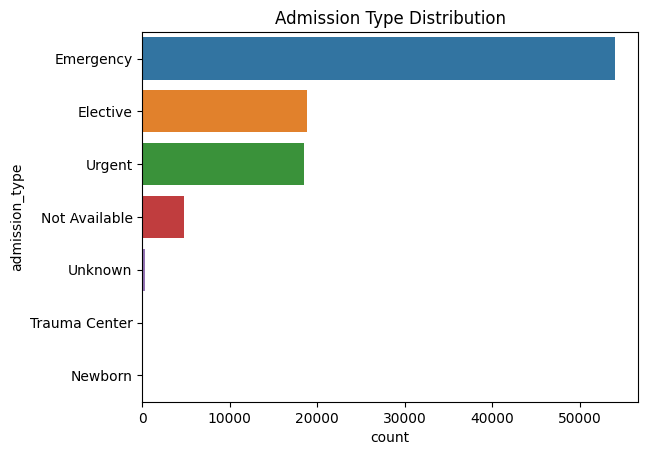

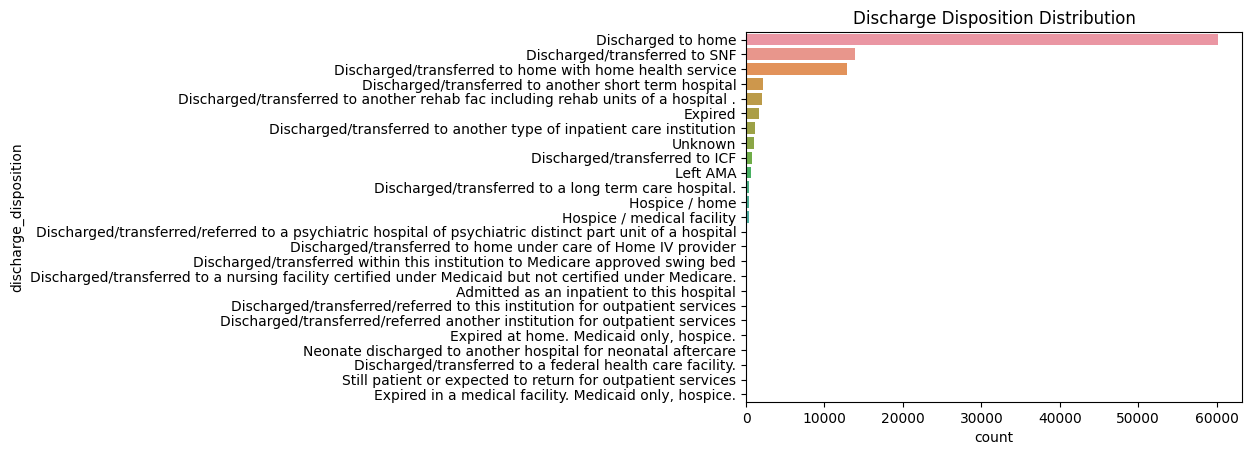

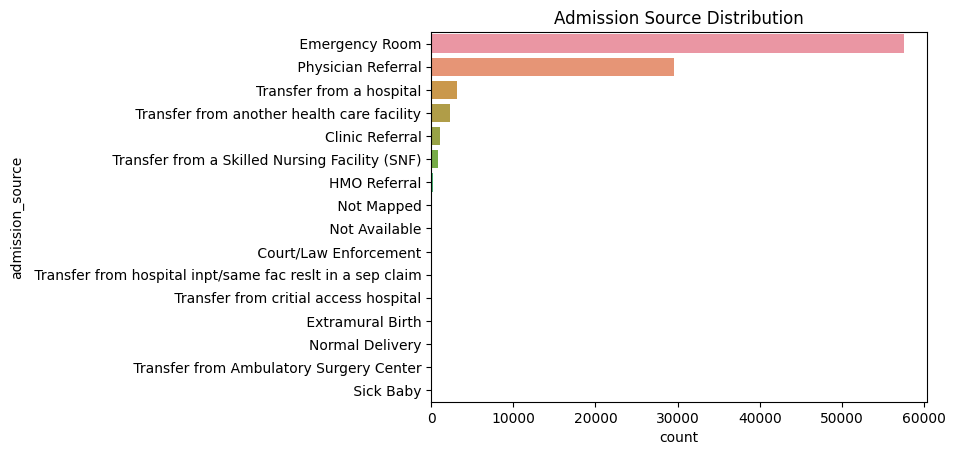

In [99]:
# Admission Type
sns.countplot(y='admission_type', data=df, order=df['admission_type'].value_counts().index)
plt.title('Admission Type Distribution')
plt.show()

# Discharge Disposition
sns.countplot(y='discharge_disposition', data=df, order=df['discharge_disposition'].value_counts().index)
plt.title('Discharge Disposition Distribution')
plt.show()

# Admission Source
sns.countplot(y='admission_source', data=df, order=df['admission_source'].value_counts().index)
plt.title('Admission Source Distribution')
plt.show()

In [100]:
# percentage of missing values for each column in the dataset. 
(df.isnull().sum() / len(df)) * 100

encounter_id                0.000000
patient_nbr                 0.000000
race                        0.000000
gender                      0.000000
age                         0.000000
time_in_hospital            0.000000
payer_code                  0.000000
medical_specialty           0.000000
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000000
diag_2                      0.000000
diag_3                      0.000000
number_diagnoses            0.000000
max_glu_serum               0.000000
A1Cresult                   0.000000
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
chlorpropamide              0.000000
glimepiride                 0.000000
acetohexamide               0.000000
glipizide                   0.000000
g

In [101]:
# Outlier Analysis for Numeric Features
numeric_features = ['num_lab_procedures', 'num_medications', 'time_in_hospital']
print(df[numeric_features].describe())

       num_lab_procedures  num_medications  time_in_hospital
count       101766.000000    101766.000000     101766.000000
mean            43.095641        16.021844          4.395987
std             19.674362         8.127566          2.985108
min              1.000000         1.000000          1.000000
25%             31.000000        10.000000          2.000000
50%             44.000000        15.000000          4.000000
75%             57.000000        20.000000          6.000000
max            132.000000        81.000000         14.000000


In [102]:
# Correlation Matrix
# Automatically select numeric features
numeric_features = df.select_dtypes(include=['number'])

# Show the selected numeric columns
print(numeric_features.columns)

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses'],
      dtype='object')


In [103]:
# Compute the correlation matrix
correlation_matrix = numeric_features.corr()

# Display the correlation matrix
print(correlation_matrix)

                    encounter_id  patient_nbr  time_in_hospital  \
encounter_id            1.000000     0.512028         -0.062221   
patient_nbr             0.512028     1.000000         -0.024092   
time_in_hospital       -0.062221    -0.024092          1.000000   
num_lab_procedures     -0.026062     0.015946          0.318450   
num_procedures         -0.014225    -0.015570          0.191472   
num_medications         0.076113     0.020665          0.466135   
number_outpatient       0.103756     0.103379         -0.008916   
number_emergency        0.082803     0.062352         -0.009681   
number_inpatient        0.030962     0.012480          0.073623   
number_diagnoses        0.265149     0.226847          0.220186   

                    num_lab_procedures  num_procedures  num_medications  \
encounter_id                 -0.026062       -0.014225         0.076113   
patient_nbr                   0.015946       -0.015570         0.020665   
time_in_hospital              0.31845

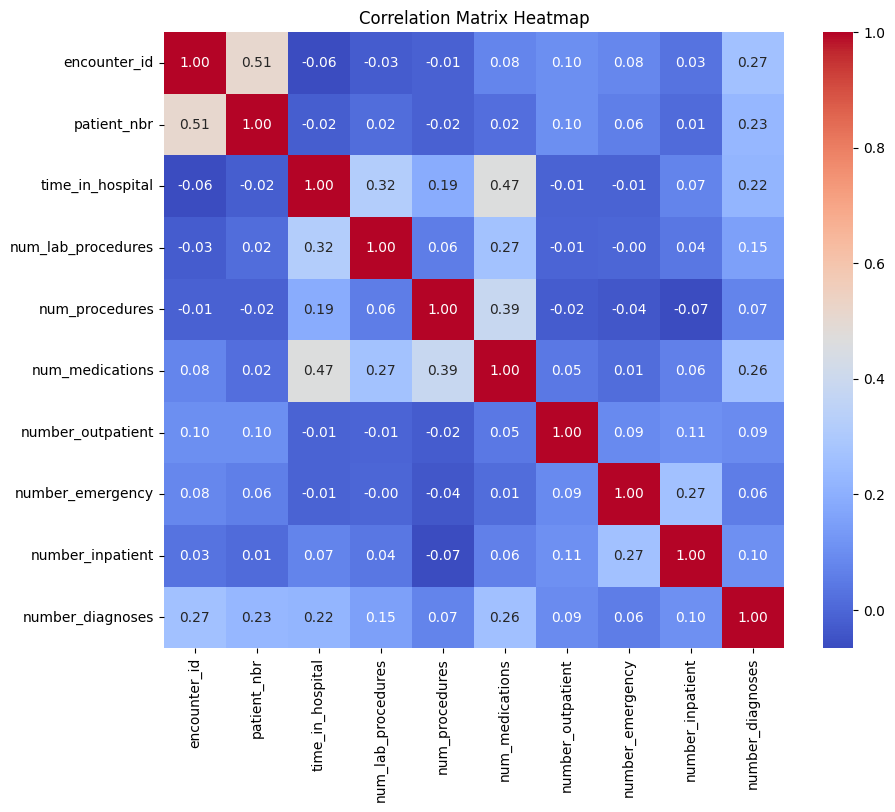

In [104]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [105]:
# Filter correlations above a threshold
threshold = 0.5
strong_corr = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)]
print(strong_corr)

                    encounter_id  patient_nbr  time_in_hospital  \
encounter_id            1.000000     0.512028               NaN   
patient_nbr             0.512028     1.000000               NaN   
time_in_hospital             NaN          NaN               1.0   
num_lab_procedures           NaN          NaN               NaN   
num_procedures               NaN          NaN               NaN   
num_medications              NaN          NaN               NaN   
number_outpatient            NaN          NaN               NaN   
number_emergency             NaN          NaN               NaN   
number_inpatient             NaN          NaN               NaN   
number_diagnoses             NaN          NaN               NaN   

                    num_lab_procedures  num_procedures  num_medications  \
encounter_id                       NaN             NaN              NaN   
patient_nbr                        NaN             NaN              NaN   
time_in_hospital                   Na

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

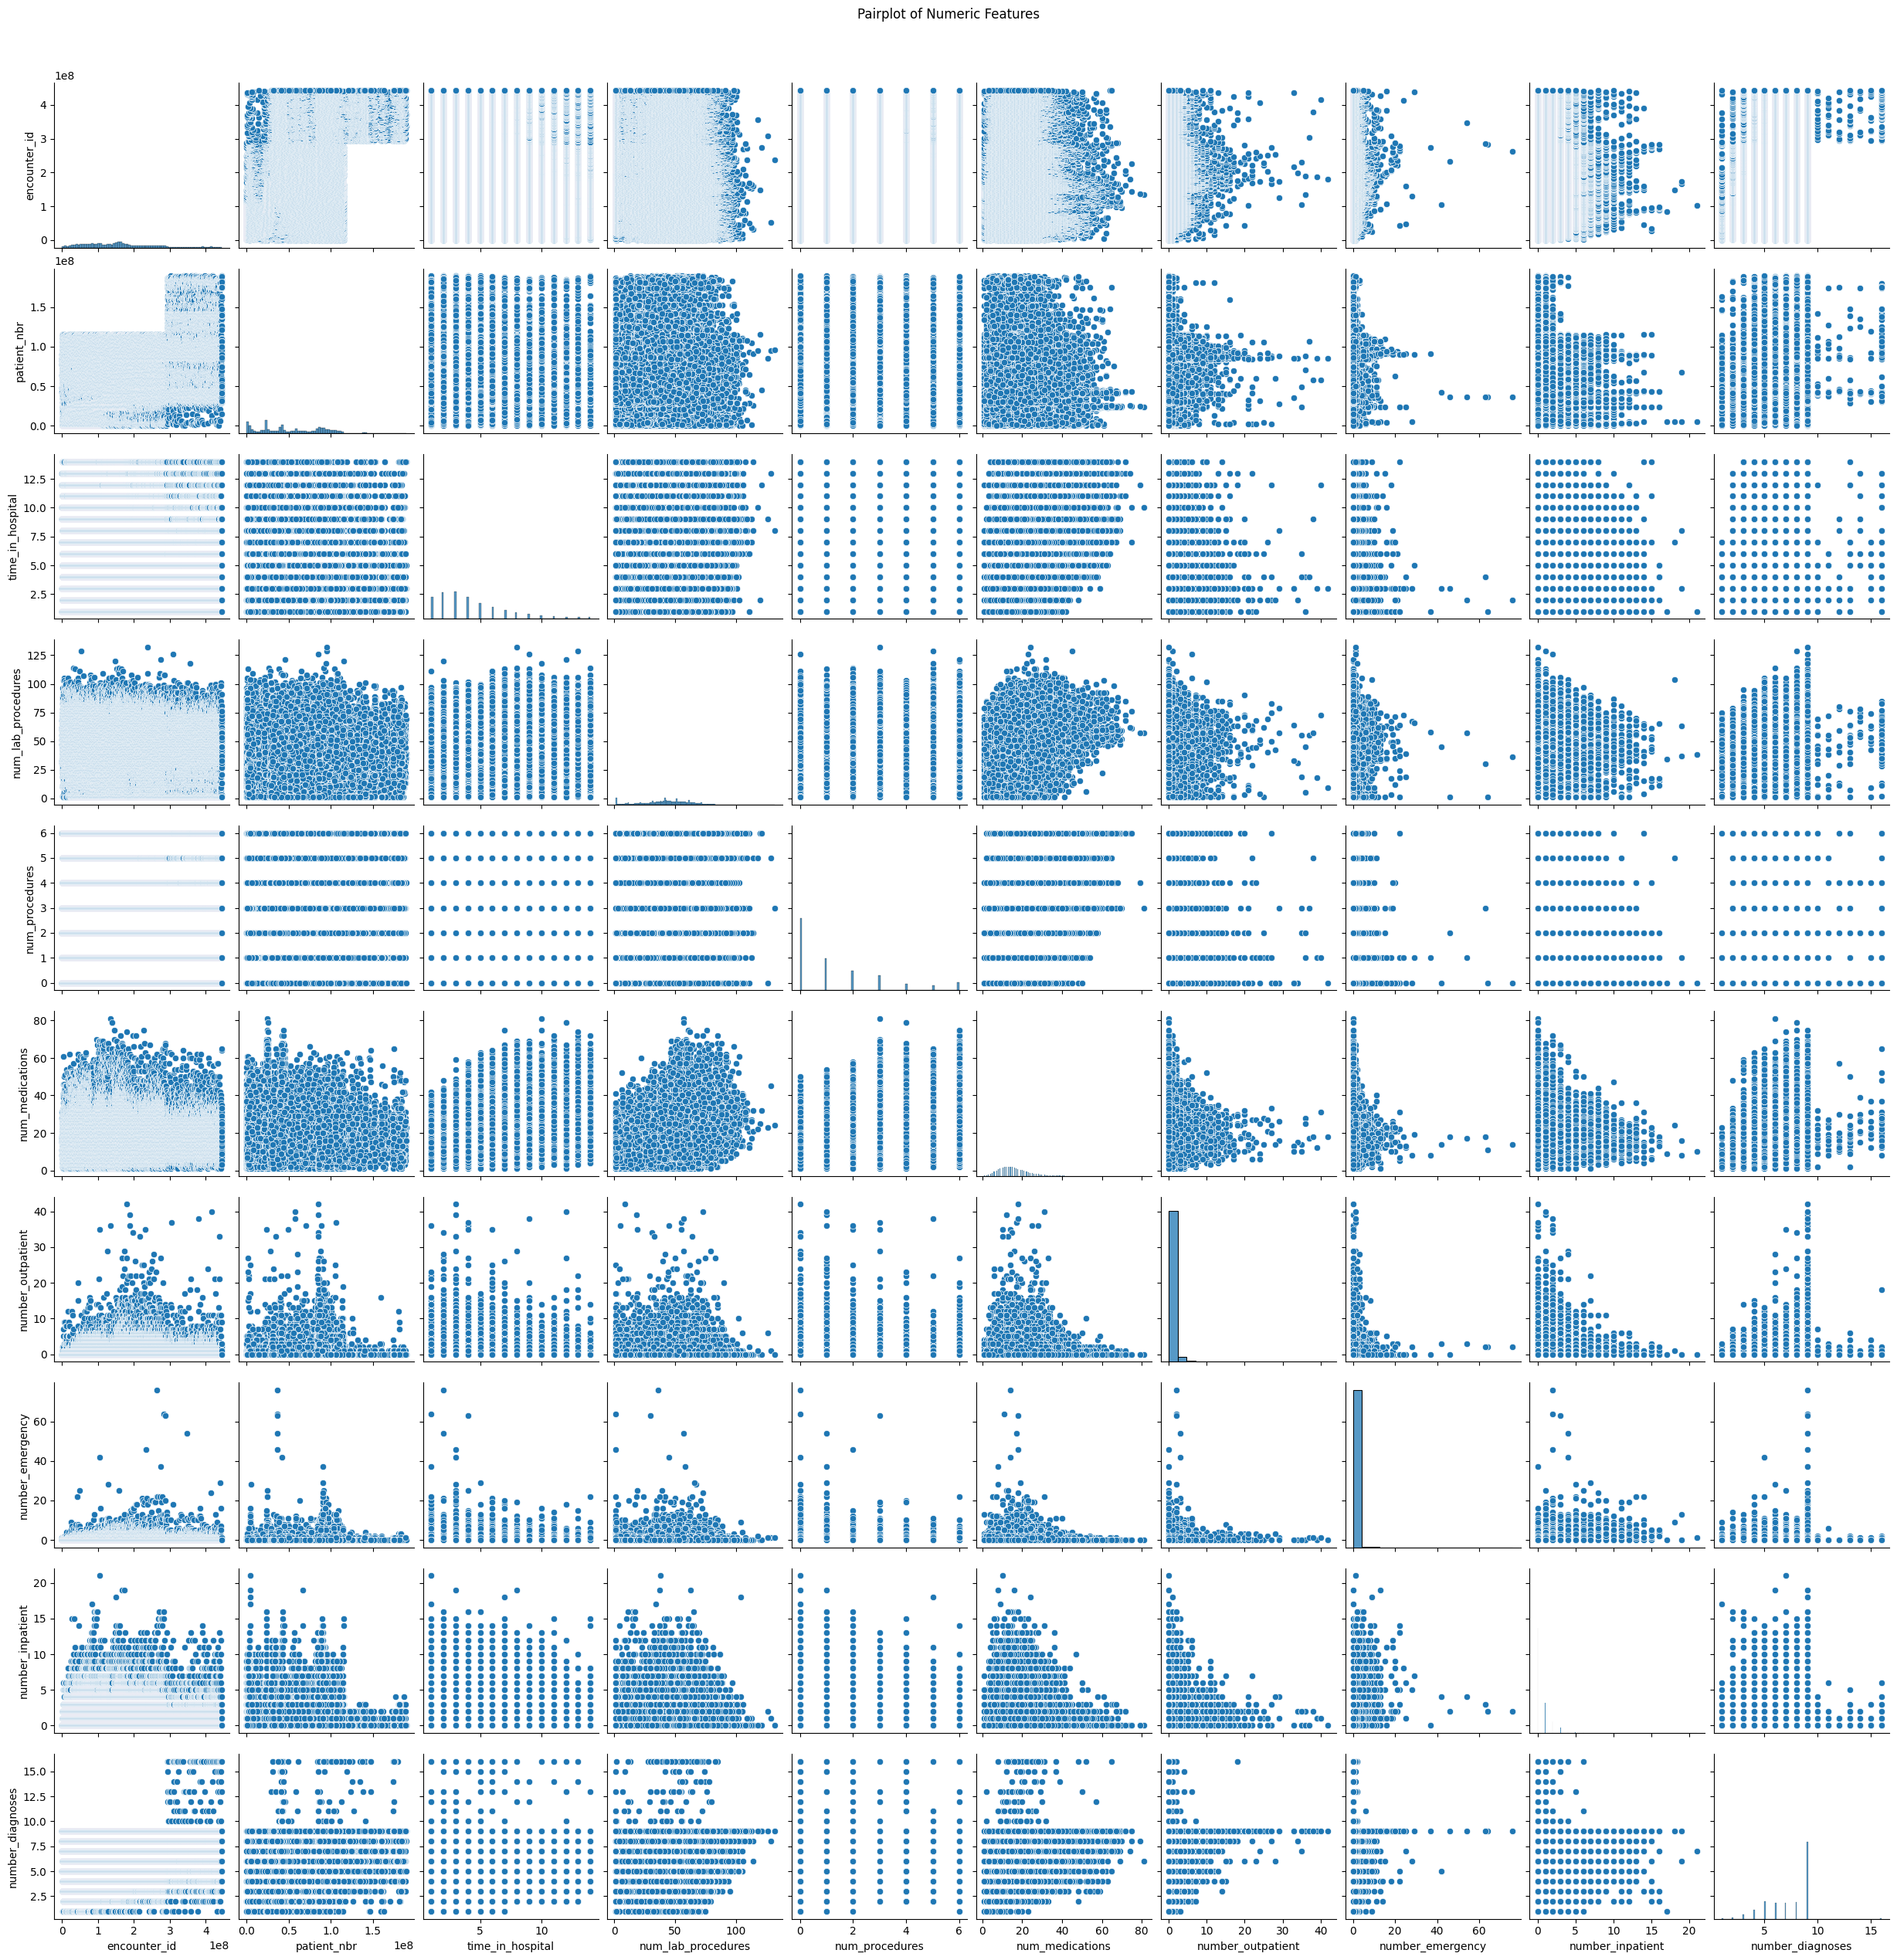

In [106]:
sns.pairplot(numeric_features)
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

In [107]:
# Combine >30 and NO into a single "Not <30" class
df['readmitted_binary'] = df['readmitted'].apply(lambda x: '<30' if x == '<30' else 'Not <30')

In [108]:
df.isnull().sum()

encounter_id                   0
patient_nbr                    0
race                           0
gender                         0
age                            0
time_in_hospital               0
payer_code                     0
medical_specialty              0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                         0
diag_2                         0
diag_3                         0
number_diagnoses               0
max_glu_serum                  0
A1Cresult                      0
metformin                      0
repaglinide                    0
nateglinide                    0
chlorpropamide                 0
glimepiride                    0
acetohexamide                  0
glipizide                      0
glyburide                      0
tolbutamide                    0
pioglitazone                   0
rosiglitaz

In [109]:
# Replace missing values in categorical features with 'Unknown'
categorical_with_missing = ['admission_type', 'discharge_disposition', 'admission_source']
for col in categorical_with_missing:
    df[col] = df[col].fillna('Unknown')

In [110]:
# Identify categorical variables
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_columns)

Categorical columns: Index(['race', 'gender', 'age', 'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type', 'discharge_disposition', 'admission_source',
       'readmitted_binary'],
      dtype='object')


## Data Preparation

In [111]:
# Separate features and target
X = df.drop(columns=['readmitted', 'readmitted_binary', 'encounter_id', 'patient_nbr'])  
# Usually, you drop ID columns since they are not predictive.
y = df['readmitted_binary']

# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


In [112]:
#for col in categorical_columns:
#    print(f"Value counts for column '{col}':")
#    print(df[col].value_counts())
#    print("-" * 40)

### Merge Low-Frequency Categories

In [118]:
# Define a function that merges categories below a certain frequency threshold into "Other".
def merge_low_freq_categories(df, column, threshold=100):
    """
    Merge categories in the specified column that occur less than 'threshold' times into 'Other'.

    Parameters:
    df : pd.DataFrame
        The dataframe containing the column to modify.
    column : str
        The column name whose categories you want to merge.
    threshold : int
        Categories with frequency below this threshold will be merged into 'Other'.

    Returns:
    df : pd.DataFrame
        The modified dataframe with low-frequency categories merged.
    """
    # Count the frequency of each category
    freq = df[column].value_counts()
    # Identify categories to merge
    low_freq_cats = freq[freq < threshold].index
    # Replace those categories with 'Other'
    df[column] = df[column].replace(low_freq_cats, 'Other')
    return df

# Example usage:
# Apply this function to columns where you have identified many low-frequency categories.
# You can adjust the threshold based on EDA and model performance.
for col in ['medical_specialty', 'payer_code', 'admission_type', 'discharge_disposition', 'admission_source']:
    df = merge_low_freq_categories(df, col, threshold=100) 


## Preprocessor

In [119]:
# Build a column transformer to encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
    ],
    remainder='passthrough'  # Keep numeric features as they are
)

## Custom Threshold Classifier

In [120]:
# Custom classifier to adjust decision threshold after prediction
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, threshold=0.5, positive_class='<30'):
        self.base_estimator = base_estimator
        self.threshold = threshold
        self.positive_class = positive_class
    
    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        return self
    
    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)
    
    def predict(self, X):
        # Find the index of the positive class
        classes = self.base_estimator.classes_
        pos_index = list(classes).index(self.positive_class)
        
        probs = self.predict_proba(X)[:, pos_index]
        return np.where(probs > self.threshold, self.positive_class, 
                        [c for c in classes if c != self.positive_class][0])


## Data Splitting

In [121]:
# Split the data into train, validation, and test sets
# First, split into train+temp and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Then split the temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 61059
Validation set size: 20353
Test set size: 20354


## Pipeline Definition

In [122]:
# Define the base estimator
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Wrap it with our ThresholdClassifier (we start with the default threshold=0.5)
threshold_clf = ThresholdClassifier(base_estimator=rf, threshold=0.5, positive_class='<30')

# Build the pipeline with preprocessing, SMOTE, and the custom classifier
pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', threshold_clf)
])


## Model Training and Evaluation

In [123]:
# Fit on the training data
pipeline.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = pipeline.predict(X_val)

print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation Set Classification Report:
              precision    recall  f1-score   support

         <30     0.3750    0.0053    0.0104      2271
     Not <30     0.8888    0.9989    0.9407     18082

    accuracy                         0.8880     20353
   macro avg     0.6319    0.5021    0.4755     20353
weighted avg     0.8315    0.8880    0.8369     20353



In [124]:
# If recall for '<30' is too low, try adjusting the threshold
pipeline.named_steps['clf'].threshold = 0.01  # Example: lower threshold to increase recall
y_val_pred_adjusted = pipeline.predict(X_val)

print("Validation Set Classification Report (Adjusted Threshold):")
print(classification_report(y_val, y_val_pred_adjusted, digits=4))


Validation Set Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

         <30     0.1422    0.7125    0.2371      2271
     Not <30     0.9273    0.4603    0.6152     18082

    accuracy                         0.4884     20353
   macro avg     0.5347    0.5864    0.4262     20353
weighted avg     0.8397    0.4884    0.5730     20353



['<30' 'Not <30']
